In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.lines import Line2D
import sys
from dataclasses import dataclass # Requires Python version 3.7
from PIL import Image

In [2]:
# Allow using a GPU or not. cupy will not be imported unless needed.
# The npcp alias will be used to either numpy or cupy based on the configuration to allow using a GPU or not.

globalUseGPU = True
if globalUseGPU:
    import cupy as cp
    npcp = cp
else:
    npcp = np

In [3]:
# Get the Dataset

# Pull from a local csv file first if it exists, so that the dataset does not have to be downloaded everytime.
datasetLoaded = False

try:
    full_df = pd.read_csv("fullMnist.csv", index_col=0)
    datasetLoaded = True
except:
    pass

if not datasetLoaded:
    try:
        # Pull from the azure opendatasets. Azure is used because it provides functionality to convert to a pandas dataframe
        # Pull from azure requires dotnet for some reason which can be difficult to use from linux

        from azureml.opendatasets import MNIST

        mnist = MNIST.get_tabular_dataset()
        full_df = mnist.to_pandas_dataframe()
        datasetLoaded = True
    except: 
        pass

# Tensforflow dataset included incase azure cannot be used
# No try here so it will just error if the dataset cannot be pulled.
if not datasetLoaded:

    import tensorflow as tf

    mnist = tf.keras.datasets.mnist
    (x_train, y_train), (x_test, y_test) = mnist.load_data()

    # Package the data into a dataframe in the way that the azure does it, which is how the code expects it
    train_data = np.hstack((x_train.reshape(60000,784), y_train.reshape(60000,1)))
    test_data = np.hstack((x_test.reshape(10000,784), y_test.reshape(10000,1)))
    full_df = pd.DataFrame(np.vstack((train_data, test_data)))
    full_df = full_df.rename(columns={784: 'label'})

2023-12-11 18:08:22.677503: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-11 18:08:22.677552: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-11 18:08:22.678196: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-11 18:08:22.683181: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-11 18:08:23.309819: W tensorflow/compiler/tf2

In [4]:
@dataclass
class ModelClass:
    clazz: str
    firstIndex: int
    lastIndex: int

class TimsClassifier:
    """
    This class uses linear determinant analysis to classify data.
    It allows the use of GPU acceleration for the training of the model, to utilize a GPU with this class follow these instructions.
        1. Specify whether a GPU should be utilized in a "globalUseGPU" variable. 'True' means to utilize the GPU and 'False' means to only use CPU.
        2. Set the npcp alias to use cupy if a GPU will be utilized, or to numpy if not.
    The only parts of this class that utilize a GPU are the training. When the class is initialized the data will be copied to the device,
         and the data will be copied back to the host once the Eigen values have been determined.
    Other parts of this class could benefit from GPU acceleration, but was not implemented due to time contraints.
    """
    def __init__(self, df: pd.DataFrame):
        """
        Initialize the class with the training data passed in.
        Setup some attributes that will be used throughout the training.
        Add the training data as an attribute, and transfer the training data to the device if using a GPU.
        """
        self.classes = []
        self.sampleSize: int
        self.classMeans = []
        # Utilize pandas functionality to sort the data by classes and find the indexes for all classes
        data = df.sort_values(by=['label'])
        data = data.reset_index(drop=True)
        for clazz in data.label.unique():
            classSubsetIndexes = data.loc[data['label'] == clazz].index
            self.classes.append(ModelClass(str(clazz), classSubsetIndexes[0], classSubsetIndexes[-1]))
            
        # Keep training data as an attribute in an ndarray
        self.trainData = data.drop(columns='label').to_numpy()
        if globalUseGPU:
            # Transfer training data to device
            self.trainData = cp.asarray(self.trainData)

        self.trainLabels = data.label.to_numpy()
        self.sampleSize = self.trainData.shape[1]  
        self.numSamples = self.trainData.shape[0]
        
    def buildClassMeans(self):
        """
        Calculate the means for each class and store the means in an attribute on the class.
        """
        for clazz in self.classes:
            self.classMeans.append(npcp.mean(self.trainData[clazz.firstIndex:clazz.lastIndex + 1], axis=0))

    def withinClassCovariance(self):
        """
        Calculate the within class covariance across all classes and store it in an attribute
        """
        withinClassCov = npcp.zeros(shape=(self.sampleSize, self.sampleSize))
        for clazz in  self.classes:
            withinClassCov += self._withinClassCovarianceForClass(clazz)
        self.withinClassCovariance = withinClassCov
    
    def _withinClassCovarianceForClass(self, clazz):
        """
        Calculate the covariance within a single class and return it

        Args:
            clazz (ModelClass): The data class to calculate the covariance for
        
        Returns:
            ndarray: The covariance matrix for the specified class.
        """
        classCov = npcp.zeros(shape=(self.sampleSize, self.sampleSize))
        classIndex = self.classes.index(clazz)
        for i in range(clazz.firstIndex, clazz.lastIndex + 1):
            currentRow = npcp.subtract(self.trainData[i], self.classMeans[classIndex])
            currentRow = npcp.outer(npcp.transpose(currentRow), currentRow)
            classCov += currentRow
        return classCov

    def betweenClassCovariance(self):
        """
        Calculate the between class covariance and store it in an attribute.
        """
        sbCovariance = npcp.zeros(shape=(self.sampleSize, self.sampleSize))
        globalMean = npcp.sum(self.trainData, axis=0) / self.numSamples
        for clazz in self.classes:
            currentClass = npcp.subtract(self.classMeans[self.classes.index(clazz)], globalMean)
            currentClass = npcp.outer(npcp.transpose(currentClass), currentClass)
            # Scale by the number of samples of this class
            currentClass = currentClass * (clazz.lastIndex + 1 - clazz.firstIndex)
            sbCovariance += currentClass
        self.betweenClassCovariance = sbCovariance

    def getSortedEigens(self):
        """
        Calculates the Eigen values and Eigen vectors for the weight matrix.
        The Eigen Values have an extra column that corresponds to the index of its Eigen vector.
        This way the Eigen values can be sorted without needing to sort the Eigen vectors.
        Both the sorted Eigen valuea and the eigen vectors are stored as attributes.
        """
        weightMatrix = npcp.matmul(npcp.linalg.pinv(self.withinClassCovariance), self.betweenClassCovariance)
        eigenValues, self.eigenVectors = npcp.linalg.eigh(weightMatrix)
        # Transpose the eigenVectors because of the way it returns and the way it is being indexed
        self.eigenVectors = npcp.transpose(self.eigenVectors)        
        # Add index for each eigenvalue so that it can be correllated to its eigenvector after a sort
        eigenValues = npcp.c_[eigenValues, range(0, eigenValues.shape[0])]
        # Sort the eigenValues largest first
        self.sortedEigenValues = npcp.flip(eigenValues[eigenValues[:,0].argsort()], axis=0)
    
    def createMapToLowerDimensionality(self, lowerDimension: int):
        """
        Create a mapping to the lower dimensionality specified by the argument. 
        The map is stored as an attribute.

        Args:
            lowerDimension (int): The number of dimensions to project the data to.
        """
        self.lowerDimension = lowerDimension
        self.w = np.zeros(shape=(self.lowerDimension, self.sampleSize), dtype=np.complex128)
        for i in range(0, self.lowerDimension):
            self.w[i] = self.eigenVectors[int(self.sortedEigenValues[i][1].real)]
        self.w = np.transpose(self.w)

    def projectDataToLowerDimension(self):
        """
        Project the training data to the lower dimensionality and store in an attribute.
        """
        self.projectedData = np.matmul(self.trainData, self.w)

    def projectedMetrics(self):
        """
        Calculate the metrics (mean, covariance, priors) for the projected data. Store in attributes.
        """
        self.projectedMeans = np.zeros(shape=(len(self.classes), self.lowerDimension))
        self.projectedCov = np.zeros(shape=(len(self.classes), self.lowerDimension, self.lowerDimension))
        self.projectedPriors = np.zeros(shape=(len(self.classes), self.lowerDimension))
        for clazz in self.classes:
            indexForClass = self.classes.index(clazz)
            self.projectedMeans[indexForClass], self.projectedCov[indexForClass], self.projectedPriors[indexForClass] = self._projectedMetricsForClass(clazz)

    def _projectedMetricsForClass(self, clazz):
        """
        Calculate the projected metrics for the class passed in.

        Args:
            clazz (ModelClass): The class to calculate the metrics for.
        
        Returns:
            ndarray: means for the projected data of the class passed in.
            ndarray: covariance for the projected data of the class passed in.
            ndarray: Prior for the class passed in.
        """
        classSubset = self.trainData[clazz.firstIndex:clazz.lastIndex + 1]
        numSamplesForClass = clazz.lastIndex + 1 - clazz.firstIndex
        projectedClassSubset = np.matmul(classSubset, self.w).real
        classSubsetMeans = np.mean(projectedClassSubset, axis=0)
        classSubsetCov = np.cov(projectedClassSubset, rowvar=False)
        classSubsetPriors = numSamplesForClass / self.numSamples
        return classSubsetMeans, classSubsetCov, classSubsetPriors
    
    def getPredictionForSingleSample(self, sample):
        """
        Get the prediction for the single sample passed in.

        Args:
            sample: The sample to get a prediction for. This dimensionality of the sample must match the dimensionality of the training data.
        
        Returns:
            str: The prediction for the sample.
        """
        projectedSample = np.matmul(sample, self.w)
        likelihoodForClass = np.zeros(shape=(len(self.classes)), dtype=np.complex128)
        for clazz in self.classes:
            indexForClass = self.classes.index(clazz)
            likelihoodForClass[indexForClass] = (self.projectedPriors[indexForClass] * self.gaussianDistribution( projectedSample,
                                        self.projectedMeans[indexForClass], self.projectedCov[indexForClass]))[0]
        return self.classes[np.argmax(likelihoodForClass)].clazz

    # rewrite?
    def score(self, testData, testLabels):
        """
        Take in the test data and labels and score the model based on that test data.

        Args:
            testData (ndarray): The data to be tested. Has the dimensionality (n x features) where the features is equal to the features of the training data.
                 n can be any number of samples.
            lables (ndarray): The labels for the testing data. This is used to verify against the predictions and must have the same length of the test data samples.

        Returns:
            float: The accuracy of the model. The number of correct predictions divided by the total test samples.
            ndarray: The predictions made by the model.
            ndarray: The test data projected to the lower dimensionality of the model.
        """
        # Project the test data to the lower dimensionality
        projectedData = np.matmul(testData, self.w)
        testDataLikelihoods = np.zeros(shape=(projectedData.shape[0], len(self.classes)))
        
        # Calculate the likelihoods for each sample
        for sampleIndex, sample in enumerate(projectedData):
            likelihoodForClass = np.zeros(shape=(len(self.classes)), dtype=np.complex128)
            # Calculate the likelihood for each class on a gaussian distribution. The class with the greatest likelihood will be the prediction.
            for clazz in self.classes:
                indexForClass = self.classes.index(clazz)
                likelihoodForClass[indexForClass] = (self.projectedPriors[indexForClass] * self.gaussianDistribution( sample,
                                        self.projectedMeans[indexForClass], self.projectedCov[indexForClass]))[0]
            testDataLikelihoods[sampleIndex] = likelihoodForClass
        predictions = np.argmax(testDataLikelihoods, axis=1)
        return np.sum(predictions == testLabels) / len(testLabels), predictions, projectedData

    # rewrite?
    def gaussianDistribution(self, data, mean, cov):
        """
        Calculate the likelihood of class for a test sample using a gaussian distribution.
        
        Args:
            data (ndarray): The test sample to calculate likelihoods for in the lower dimensionality.
            mean (ndarray): The mean of the class to calculate the likelihood for.
            cov (ndarray): The covariance of the class to calculate the likelihood for.
        
        Returns:
            float: The likelihood of the class for this test sample.
        """
        detCov = np.linalg.det(cov)
        # Avoid divide by zero errors
        if detCov == 0:
            detCov = sys.float_info.min
        # Avoid sqrt negative numbers
        if detCov < 0:
            detCov = detCov * -1
        scalar = (1. / ((2 * np.pi) ** (data.shape[0] / 2.))) * (1/ np.sqrt(detCov))
        diffMean = np.subtract(data, mean)
        return scalar * np.exp(-np.dot(np.dot(diffMean, np.linalg.pinv(cov)), diffMean.T) / 2.)
    
    def transferDataToHost(self):
        """
        Transfer the data from the device (GPU) to the host after calcuations are done.
        Data being transfered - Training data, Eigen Values, Eigen Vectors, and class means.
        """
        # Data needed to be tansfered: training data, eigenvalues, eigenvectors
        self.trainData = cp.asnumpy(self.trainData)
        self.sortedEigenValues = cp.asnumpy(self.sortedEigenValues)
        self.eigenVectors = cp.asnumpy(self.eigenVectors)
        for i in range(0, len(self.classMeans)):
            self.classMeans[i] = cp.asnumpy(self.classMeans[i])
        
    def train(self):
        """
        Train the model. This starts after taking in the raw data, and the ends after calculating the Eigen values and vectors.
        """
        self.buildClassMeans()
        self.withinClassCovariance()
        self.betweenClassCovariance()
        self.getSortedEigens()
        if globalUseGPU:
            self.transferDataToHost()
        
    def LowerDimensionality(self, lowerDimensions: int):
        """
        Lower the dimensionality of the training data based on the Eigen values and vectors calculated.
        Must be called after train.
        """
        self.createMapToLowerDimensionality(lowerDimensions)
        self.projectDataToLowerDimension()
        self.projectedMetrics()
        

In [8]:
# Setup the data to be used
# In the MNIST dataset, the first 60000 samples are training data, and the last 10000 are test data

newClassifier = TimsClassifier(full_df.head(60000))
testData = full_df.tail(10000).drop(columns='label').to_numpy()
testLabels = full_df.tail(10000).label.to_numpy()

In [9]:
newClassifier.train()

In [10]:
# Calculate the accuracy across many dimensions

dimensions = [1,2,3]
accuracies = []

for d in dimensions:
    newClassifier.LowerDimensionality(d)
    accuracy, predictions, projectedData = newClassifier.score(testData, testLabels)
    accuracies.append(accuracy)


/tmp/ipykernel_8812/333504913.py:203: ComplexWarning: Casting complex values to real discards the imaginary part
  testDataLikelihoods[sampleIndex] = likelihoodForClass


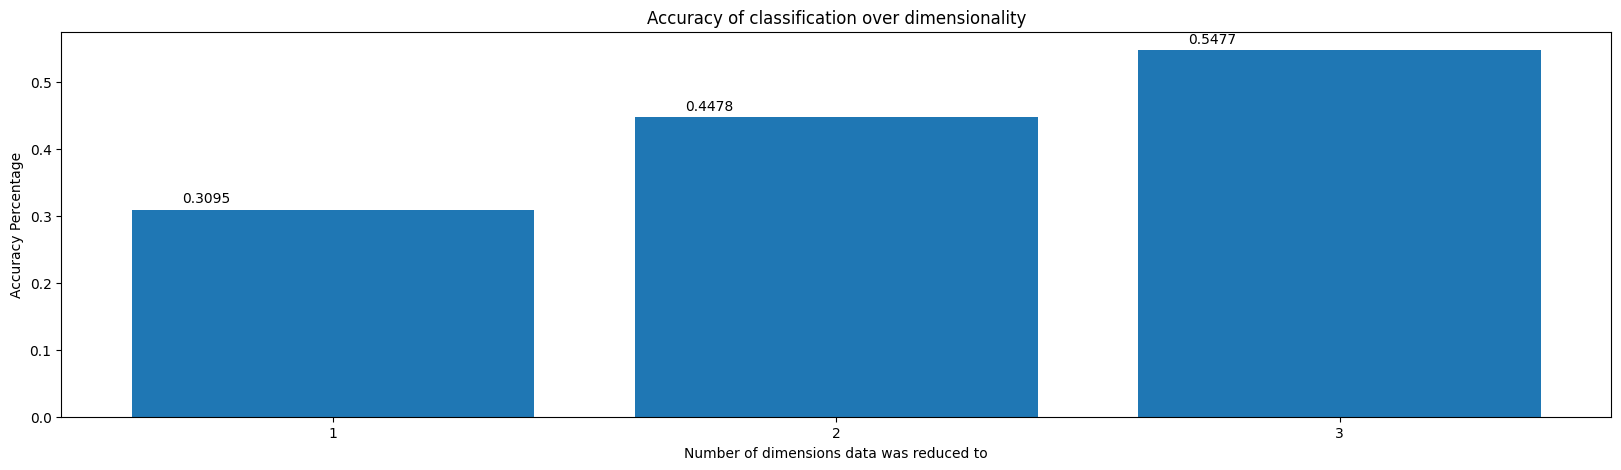

In [11]:
# Draw a bar graph showing how accurate the classification is across dimensions

plt.figure(figsize = (20,5))
plt.xticks(dimensions)

plt.title("Accuracy of classification over dimensionality")
plt.ylabel("Accuracy Percentage")
plt.xlabel("Number of dimensions data was reduced to")

plt.bar(dimensions, accuracies)
for bar in zip(dimensions, accuracies):
    plt.text(bar[0] - 0.3, bar[1] + 0.01, bar[1])

plt.show()

<Figure size 1600x600 with 0 Axes>

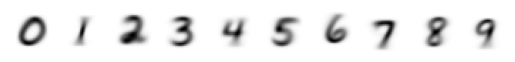

In [12]:
# Draw the means for each class. This gives an idea of what the model will be looking for, and is

count = 0
sample_size = 10
plt.figure(figsize=(16, 6))
fig, ax = plt.subplots(nrows = 1, ncols = len(newClassifier.classMeans))

for i, col in enumerate(ax):
    col.set_axis_off()
    col.imshow(newClassifier.classMeans[i].reshape(28,28), cmap=plt.cm.Greys)
plt.show()

In [13]:
# Some common code for plotting

# Project the data down to 2 dimensions so it can be plotted
newClassifier.LowerDimensionality(2)
accuracy, predictions, projectedData = newClassifier.score(testData, testLabels)

# Get colors to use for each class
colors = cm.rainbow(np.linspace(0, 1, len(newClassifier.classes)))

# Create a custom legend
customLegendPoints = []
for i,clazz in enumerate(newClassifier.classes):
    customLegendPoints.append(Line2D([0], [0], label = clazz.clazz, marker='.', markersize=10, color=colors[i], linestyle=''))


/tmp/ipykernel_8812/333504913.py:203: ComplexWarning: Casting complex values to real discards the imaginary part
  testDataLikelihoods[sampleIndex] = likelihoodForClass


/home/timmy/mlProject/lib/python3.10/site-packages/matplotlib/collections.py:194: ComplexWarning: Casting complex values to real discards the imaginary part
  offsets = np.asanyarray(offsets, float)


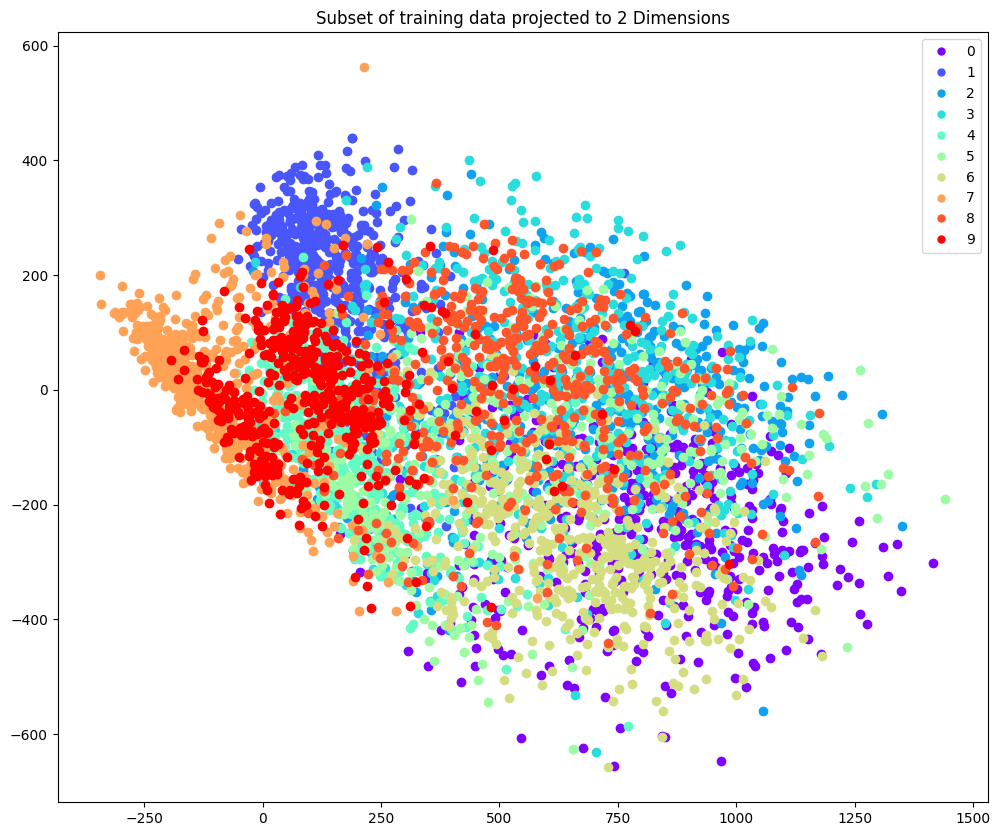

In [14]:
# Plot some of the projected data

plt.figure(figsize=(12,10))
stride = 12
for i, point in enumerate(newClassifier.projectedData[::stride]):
    plt.scatter(point[0], point[1], color=colors[newClassifier.trainLabels[i*stride]])

# Create a custom legend
customLegendPoints = []
for i,clazz in enumerate(newClassifier.classes):
    customLegendPoints.append(Line2D([0], [0], label = clazz.clazz, marker='.', markersize=10, color=colors[i], linestyle=''))

plt.title("Subset of training data projected to 2 Dimensions")
plt.legend(handles=customLegendPoints)
plt.show()

In [12]:
# Plot the projected test data and color by the known label

plt.figure(figsize=(12,10))
for point, label in zip(projectedData, testLabels):
    plt.scatter(point[0], point[1], color=colors[label])

plt.title("Test Data Projected to 2 Dimensions and Colored by Known Label")
plt.legend(handles=customLegendPoints)
plt.show()

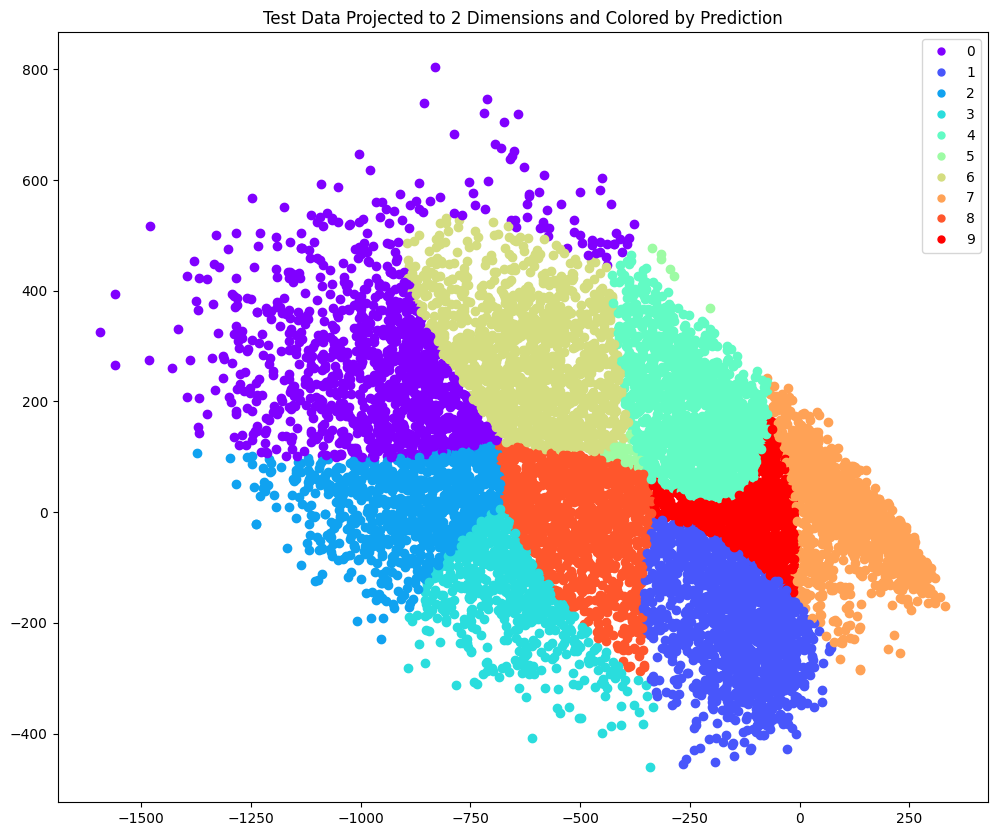

In [ ]:
# Plot the projected test data and color by the prediction

plt.figure(figsize=(12,10))
for point,pred in zip(projectedData,predictions):
  plt.scatter(point[0],point[1],color=colors[pred])

plt.title("Test Data Projected to 2 Dimensions and Colored by Prediction")
plt.legend(handles=customLegendPoints)
plt.show()

In [ ]:
# Get predictions for 3d scatter plot
newClassifier.LowerDimensionality(3)
accuracy, predictions, projectedData = newClassifier.score(testData, testLabels)

C:\Users\timmy\AppData\Local\Temp\ipykernel_28268\4160350089.py:197: ComplexWarning: Casting complex values to real discards the imaginary part
  testDataLikelihoods[sampleIndex] = likelihoodForClass


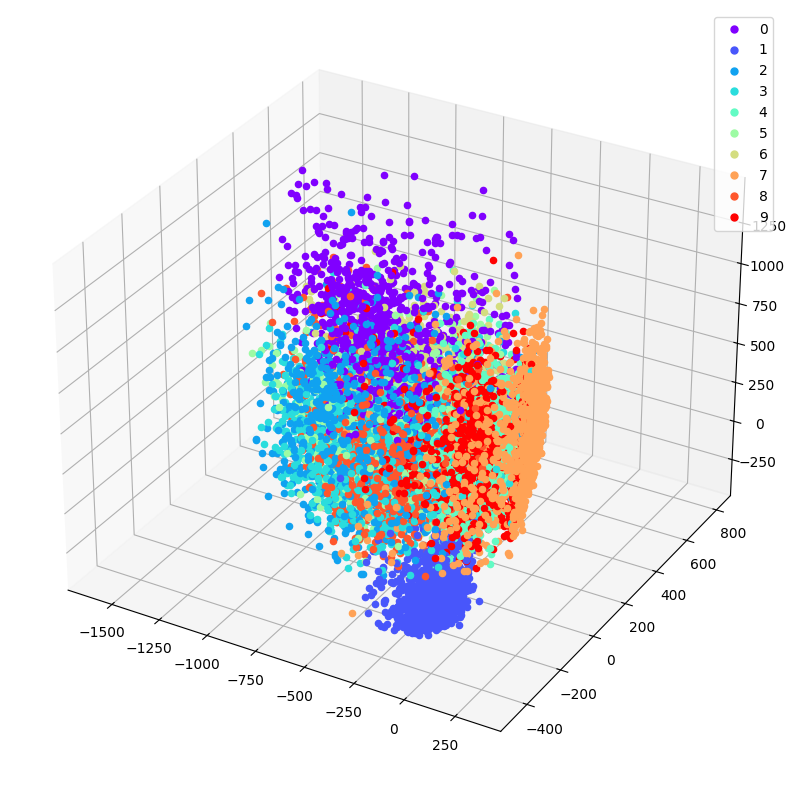

In [ ]:
# Plot predicted data in 3 dimensions with known labels

fig = plt.figure(figsize=(12,10))
ax = fig.add_subplot(projection="3d")
for point, label in zip(projectedData.real,testLabels):
  ax.scatter(point[0],point[1], point[2], color = colors[label])

plt.legend(handles=customLegendPoints)
plt.show()

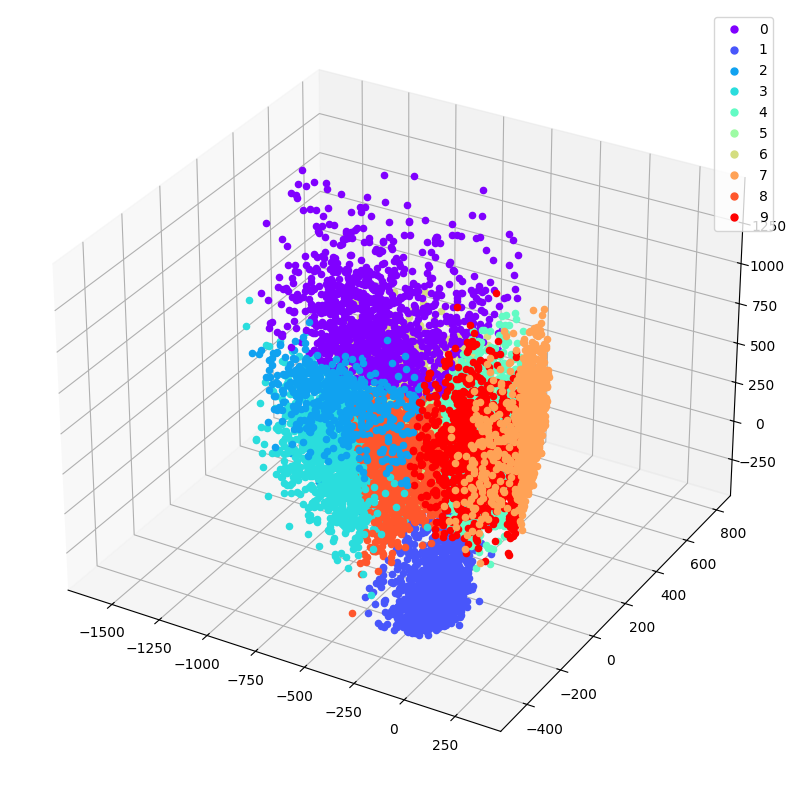

In [ ]:
# Plot predicted data in 3 dimensions with predicted labels

fig = plt.figure(figsize=(12,10))
ax = fig.add_subplot(projection="3d")
for point,pred in zip(projectedData.real,predictions):
  ax.scatter(point[0],point[1], point[2], color = colors[pred])

plt.legend(handles=customLegendPoints)
plt.show()

In [ ]:
# Show how shifting the data to the side breaks the prediction

import copy

def showShiftedPrediction(sampleIndex, row):
    shiftedSample = copy.deepcopy(testData[sampleIndex])
    shiftedSample = shiftedSample.reshape(28,28)
    # # shift each pixel to the left by 5 pixels
    for i in range(0, len(shiftedSample)):
        shiftedSample[i] = np.append(shiftedSample[i][5:], np.zeros(shape=(5), dtype = np.int64))
    shiftedSample = shiftedSample.reshape(784)

    realPrediction = newClassifier.getPredictionForSingleSample(testData[sampleIndex])
    shiftedPrediction = newClassifier.getPredictionForSingleSample(shiftedSample)

    row[0].set_xticks([])
    row[0].set_yticks([])
    row[0].set_title("Prediction = " + realPrediction)
    row[0].imshow(testData[sampleIndex].reshape(28, 28), cmap=plt.cm.Greys)
    row[1].set_xticks([])
    row[1].set_yticks([])
    row[1].set_title("Prediction = " + shiftedPrediction)
    row[1].imshow(shiftedSample.reshape(28, 28), cmap=plt.cm.Greys)



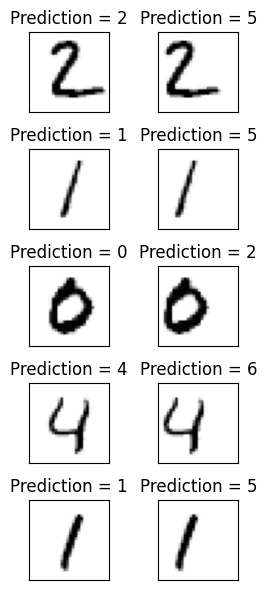

In [ ]:
# Draw a figure to show how predictions are off when image is shifted left

newClassifier.LowerDimensionality(10)

fig, ax = plt.subplots(nrows = 5, ncols = 2, figsize=(3,6))

testSamplesToUse = [1,2,3,4,5]

for i, row in enumerate(ax):
    showShiftedPrediction(testSamplesToUse[i], row)

fig.tight_layout()
plt.show()

In [ ]:
# # Get the prediction for custom images - commented out because it did not work very well. See report for explanation
# im = Image.open("big4.png").convert('L')

# zeroImage = np.asarray(im).reshape(784)

# predictedClass = newClassifier.getPredictionForSingleSample(zeroImage)

# print(predictedClass)

In [ ]:
# # Get the prediction for custom images - commented out because it did not work very well. See report for explanation
# im = Image.open("big4.png").convert('L')

# zeroImage = np.asarray(im).reshape(784)

# predictedClass = newClassifier.getPredictionForSingleSample(zeroImage)

# print(predictedClass)